<a href="https://colab.research.google.comgithub/nyp-sit/sdaai-iti107/blob/main/session-3/improved_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab" align="left"/></a>

# Improved model using Transfer Learning

Welcome to this week's programming exercise. In this exercise, we use transfer learning to improve our baseline model. We make use of a model (VGG19) that is already trained on ImageNet and use the convolutional neural network as a feature extractor and train a classifier specifically for our emotion classification task.

At the end of this exercise, you will be able to: 
- understand how to load a pretrained model with and without the classification layer  
- extract training features using the pre-trained model as feature extractor
- train a classifier using the extracted features 


In [2]:
from __future__ import print_function

import os
import json
import shutil
import numpy as np


import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.applications import VGG19
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, roc_curve, \
                            precision_recall_curve, average_precision_score, confusion_matrix
import pickle
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

## Prepare Data

In [5]:
dataset_URL = 'https://nyp-aicourse.s3.ap-southeast-1.amazonaws.com/iti107/datasets/intel_emotions_dataset.zip'
path_to_zip = tf.keras.utils.get_file('intel.zip', origin=dataset_URL, extract=True, cache_dir='.')
print(path_to_zip)

.\datasets\intel.zip


In [6]:
dataset_dir = os.path.dirname(path_to_zip)
print(dataset_dir)
pos_path = os.path.join(dataset_dir, 'Positive')
neg_path = os.path.join(dataset_dir, 'Negative')

.\datasets


In [7]:
# adjust this to larger or smaller size
img_height, img_width = 200, 200

## Pre-trained Model as Feature Extractor

We will be using VGG19 as our pretrained model (you can choose any other pretrained model, such as ResNet, etc). Keras comes with a set of [pretrained models](https://www.tensorflow.org/api_docs/python/tf/keras/applications) you can choose from. In the following call, we load the model VGG19 without including the classification layers (`include_top=False`). In the weights, we specify that we want to download the weights that was trained on ImageNet dataset.

In [8]:
model_pretrained = VGG19(include_top=False, 
                         weights="imagenet",  
                         input_shape=(img_height, img_width, 3))

model_pretrained.summary()

80142336/80134624 [==============================] - 5s 0us/step
Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200, 200, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 200, 200, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 200, 200, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 100, 100, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 100, 100, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 100, 100, 128)     147584    
______________________________________________________________

**Question:**

- What is the last layer in the pretrained model and what is the output shape? Do you have any Fully connected layers?

<details><summary>Click here for answer</summary>

The last layer is the MaxPooling2D layer. The output is a 512 feature maps of 4x4 size. There is no Fully connected (Dense) layers. The network is a convolutional base network.

</details>

In [37]:
from tensorflow.keras.applications import vgg19

vgg_preprocess_input_fn = vgg19.preprocess_input

In [39]:
datagen = ImageDataGenerator(rescale=1. / 255, validation_split=0.2, preprocessing_function=vgg_preprocess_input_fn)

In [40]:
train_gen = datagen.flow_from_directory(dataset_dir, 
                                        target_size=(img_height, img_width), 
                                        class_mode=None, 
                                        batch_size=8, 
                                        shuffle=False,
                                        subset='training')

validation_gen = datagen.flow_from_directory(dataset_dir, 
                                             target_size=(img_height, img_width), 
                                             class_mode=None, 
                                             batch_size=8, 
                                             shuffle=False,
                                             subset='validation')

Found 1305 images belonging to 2 classes.
Found 325 images belonging to 2 classes.


In [41]:
train_gen.class_indices

{'Negative': 0, 'Positive': 1}

In [42]:
train_steps_per_epoch = int(np.ceil(train_gen.n * 1. / train_gen.batch_size))
print('num of train steps per epoch {}'.format(train_steps_per_epoch))
validation_steps_per_epoch = int(np.ceil(validation_gen.n * 1. / validation_gen.batch_size))
print('num of validation steps per epoch {}'.format(validation_steps_per_epoch))

num of train steps per epoch 164
num of validation steps per epoch 41


### Extracting features on the train set 

We use `predict()` to loop through all the train images (and also the validation images). The output will be the features spit out by the convolutional base. We will then use these features as our training samples instead of the original images.

In [43]:
X_train = model_pretrained.predict(train_gen, 
                                   steps=train_steps_per_epoch, 
                                   verbose=1)

y_train = train_gen.classes

np.save(os.path.join(dataset_dir, "train_features.npy"), X_train)
np.save(os.path.join(dataset_dir, "train_classes.npy"), y_train)

164/164 [==============================] - 20s 122ms/step


In [44]:
X_valid = model_pretrained.predict(validation_gen, 
                                   steps=validation_steps_per_epoch, 
                                   verbose=1)

y_valid = validation_gen.classes

np.save(os.path.join(dataset_dir, "valid_features.npy"), X_valid)
np.save(os.path.join(dataset_dir, "valid_classes.npy"), y_valid)

print("Features are calculated!")

41/41 [==============================] - 5s 125ms/step
Features are calculated!


## Classification model

Now we will build a new model that takes in the extracted features as input. Instead of the usual flatten layer, followed by dense layers, let us use a GAP layer, followed by Dense, a Droput and another Dense that output the prediction. 

**Questions:**

1. What should be input shape to our model? 
2. What is the output shape of the Global Average Pooling (GAP) layer? 
3. How many units we need for output, and what should we use as activation function? 

Complete the code below. 

<details><summary>Click here for answer</summary>
    
1. The input shape should be (4, 4, 512) which is the output shape of our convolutional base
2. The output shape of GAP is (512) since the maxpooling layer (the last layer) of the convolutional base has 512 feature maps (channels). 
3. We need only 1 output unit as we are doing binary classification (0 or 1) and we should use 'sigmoid' as the activation function for binary classification. 

Codes: 

```
inp = Input(shape=X_train.shape[1:])
fl = GlobalAveragePooling2D()(inp)
fc1 = Dense(units=512, activation="relu", kernel_initializer="he_normal")(fl)
dp1 = Dropout(rate=0.5)(fc1)
out = Dense(units=1, activation="sigmoid")(dp1)

model_top = Model(inputs=[inp], outputs=[out], name="top")

``` 

</details>


In [45]:
# Build the model here, you can use either Keras Sequential or functional API to build your model

### START YOUR CODE HERE ###

## build your layers here, include the input layer

# define the inputs and outputs of the model 
inp = Input(shape=X_train.shape[1:])
fl = GlobalAveragePooling2D()(inp)
fc1 = Dense(units=512, activation="relu", kernel_initializer="he_normal")(fl)
dp1 = Dropout(rate=0.5)(fc1)
out = Dense(units=1, activation="sigmoid")(dp1)

model_top = Model(inputs=[inp], outputs=[out], name="top")

model_top.compile(loss="binary_crossentropy", 
                  optimizer=Adam(lr=0.0001), 
                  metrics=["accuracy"])

### END YOUR CODE HERE ###    


C:\Users\markk\miniconda3\envs\dlenv\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [46]:
model_top.summary()

Model: "top"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 6, 6, 512)]       0         
_________________________________________________________________
global_average_pooling2d_1 ( (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 513       
Total params: 263,169
Trainable params: 263,169
Non-trainable params: 0
_________________________________________________________________


Now we train our classifier we the extracted features (X_train) for 100 epochs. The training will be fast, as we only have very few parameters (around 200k) to train.

In [47]:
hist_top = model_top.fit(X_train, y_train, 
                         epochs=30, 
                         validation_data=(X_valid, y_valid), 
                         verbose=1)

model_top.save(os.path.join("model_top.h5"))
# save the history of training
with open(os.path.join('hist_top.history'), 'wb') as f:
    pickle.dump(hist_top.history, f)
hist_top = hist_top.history

Epoch 1/30
41/41 [==============================] - 1s 9ms/step - loss: 0.7430 - accuracy: 0.5287 - val_loss: 0.6812 - val_accuracy: 0.5662
Epoch 2/30
41/41 [==============================] - 0s 6ms/step - loss: 0.7257 - accuracy: 0.5418 - val_loss: 0.6644 - val_accuracy: 0.6215
Epoch 3/30
41/41 [==============================] - 0s 6ms/step - loss: 0.7019 - accuracy: 0.5640 - val_loss: 0.6527 - val_accuracy: 0.6215
Epoch 4/30
41/41 [==============================] - 0s 6ms/step - loss: 0.6901 - accuracy: 0.5747 - val_loss: 0.6427 - val_accuracy: 0.6646
Epoch 5/30
41/41 [==============================] - 0s 5ms/step - loss: 0.6820 - accuracy: 0.5762 - val_loss: 0.6361 - val_accuracy: 0.6615
Epoch 6/30
41/41 [==============================] - 0s 6ms/step - loss: 0.6636 - accuracy: 0.6046 - val_loss: 0.6298 - val_accuracy: 0.6646
Epoch 7/30
41/41 [==============================] - 0s 6ms/step - loss: 0.6539 - accuracy: 0.6230 - val_loss: 0.6228 - val_accuracy: 0.6646
Epoch 8/30
41/41 [==

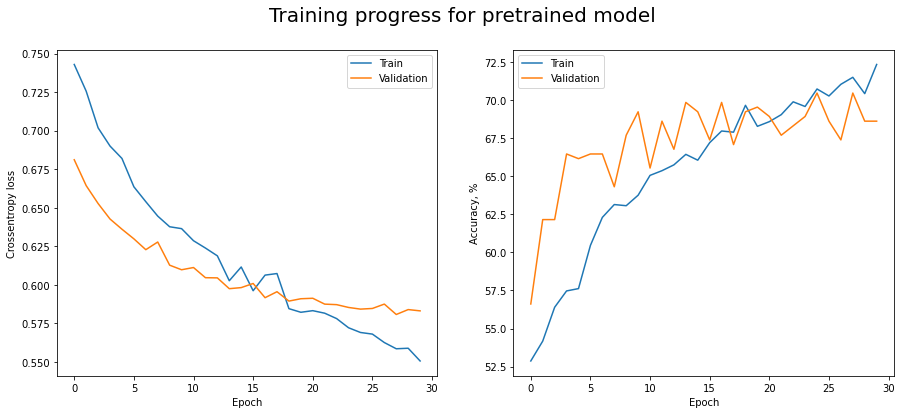

In [48]:
plt.figure(figsize=(15, 6))
plt.suptitle("Training progress for pretrained model", fontsize=20)

plt.subplot(121)
plt.plot(hist_top["loss"], label="Train")
plt.plot(hist_top["val_loss"], label="Validation")
plt.legend()
plt.ylabel("Crossentropy loss")
plt.xlabel("Epoch")

plt.subplot(122)
plt.plot(np.array(hist_top["accuracy"]) * 100, label="Train")
plt.plot(np.array(hist_top["val_accuracy"]) * 100, label="Validation")
plt.legend()
plt.ylabel("Accuracy, %")
plt.xlabel("Epoch");

In [49]:
y_pred = model_top.predict(X_valid)

In [50]:
print(classification_report(y_valid, y_pred.flatten() > 0.5))
print("Accuracy = {:.1f}%".format(accuracy_score(y_valid, y_pred.flatten() > 0.5) * 100))

              precision    recall  f1-score   support

           0       0.71      0.56      0.63       154
           1       0.67      0.80      0.73       171

    accuracy                           0.69       325
   macro avg       0.69      0.68      0.68       325
weighted avg       0.69      0.69      0.68       325

Accuracy = 68.6%


You should see an good improvement in the model (should be around 20%). The model also takes much less time to train!

## Prepare the model for deployment

We cannot just use our `model_top` that is trained for image classification, as it take extracted features as input, not image. We need to stick back our convolutional base and use an input layer of appropriate shape. This is what we are going to do below.

In [51]:
inp = Input(shape=(img_height, img_width, 3))
pretrained_output = model_pretrained(inp)
top_output = model_top(pretrained_output)

In [52]:
model_final = Model(inputs=[inp], outputs=[top_output])
model_final.compile(loss="binary_crossentropy", optimizer="Adam", metrics=["accuracy"])

In [53]:
model_final.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 200, 200, 3)]     0         
_________________________________________________________________
vgg19 (Functional)           (None, 6, 6, 512)         20024384  
_________________________________________________________________
top (Functional)             (None, 1)                 263169    
Total params: 20,287,553
Trainable params: 20,287,553
Non-trainable params: 0
_________________________________________________________________


In [54]:
model_final.save(os.path.join("pretrained_full.model.h5"))

Now let just test our full model on the images from validation set.

In [55]:
y_pred_probs = model_final.predict(validation_gen, validation_steps_per_epoch)

# convert probabilities into classification label based on threshold of 0.5 
y_pred = y_pred_probs > 0.5
y_valid = np.array(validation_gen.classes)

In [56]:
print(classification_report(y_valid, y_pred))

              precision    recall  f1-score   support

           0       0.71      0.56      0.63       154
           1       0.67      0.80      0.73       171

    accuracy                           0.69       325
   macro avg       0.69      0.68      0.68       325
weighted avg       0.69      0.69      0.68       325



### Extra exercises

1. Notice that we did not use data augmentation in the codes above.  You can try to add data augmentation and see if you can further improve the result.

2. Train with the convolutional base, but unfreeze the last few convolutional layer, and see if it improve the model (you can refer to ipython notebook *fine_tuning.ipynb* on how to do it.